In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from las import LASReader

In [30]:
file = r'./data/7120_12_3.las'


In [4]:
data = LASReader(file, null_subs=np.nan)

#

#DT = data.data['DTC'][~np.isnan(data.data['DTC'])]


In [5]:
data.curves.items
data.well.items

KB_elev = float(data.well.EKB.data)  # Kelly Bushing elevation
water_depth = float(data.well.EGL.data) # Depth to Sea Floor below sea level
top_of_log = float(data.well.STRT.data)

print ("KB elevation [m]: ", KB_elev) # Kelly Bushing (ft)
print ("Seafloor elevation [m]: ", water_depth) # Depth to sea floor below sea level
print ("Top of sonic log [m]: ", top_of_log)  

#-----------------#
# replacement interval between SRD and seabed
water_vel = 1480  # velocity of sea water [m/s]
water_twt = abs(water_depth) / water_vel
print ("One-way water_time: ", water_twt)


#----------------#
# replacement interval between seabed and top of log
repl_int = top_of_log - abs(water_depth) # Depth[m]
repl_vel = 1800                     # m/s
repl_time = repl_int / repl_vel
log_start_time = water_twt + repl_time
log_start_comb_vel = top_of_log / log_start_time


print ('SRD to log, time:', log_start_time)
print ("Seabed to top of log replacement interval [m]: ", repl_int)
print ("Seabed to top of log two-way-replacement time [sec]: ", repl_time)
print ("Combined velocity to top of log [m/s]", log_start_comb_vel)

KB elevation [m]:  23.0
Seafloor elevation [m]:  -185.0
Top of sonic log [m]:  299.962
One-way water_time:  0.125
SRD to log, time: 0.18886777777777777
Seabed to top of log replacement interval [m]:  114.96199999999999
Seabed to top of log two-way-replacement time [sec]:  0.06386777777777777
Combined velocity to top of log [m/s] 1588.2116236520553


In [6]:
#df=pd.read_csv(file, skiprows=37, sep='\s+', na_values='-999.0000', header=None)
df = pd.DataFrame(data.data)
df['vi']=304800/df.DT
df['sonic_metric'] = df.DT * 3.2808
df['TVDSS'] = df.TVD + KB_elev

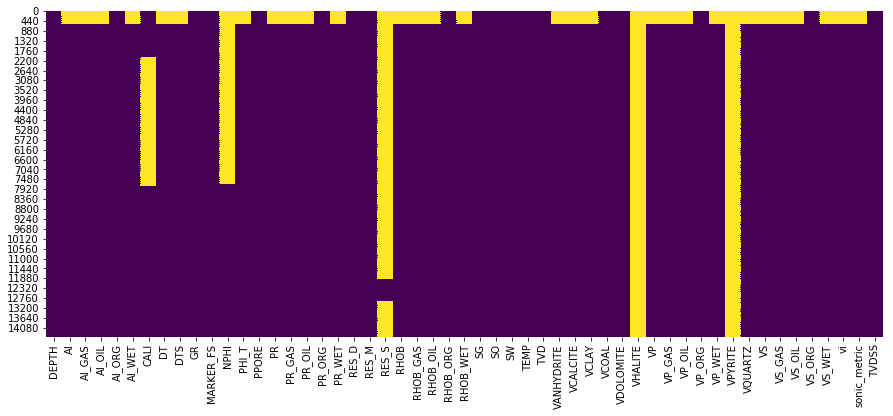

In [7]:
plt.figure(figsize=(15,6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)

In [8]:
df = df.dropna(how='all', axis=1) # drop columns with all values missing
# fillna(values around the missing)

In [9]:
df = df.dropna(thresh=1000, axis=1) # keep columns that have more than 1000 

In [10]:
df = df.drop(['CALI', 'NPHI'], axis=1)

In [11]:
df = df.dropna()

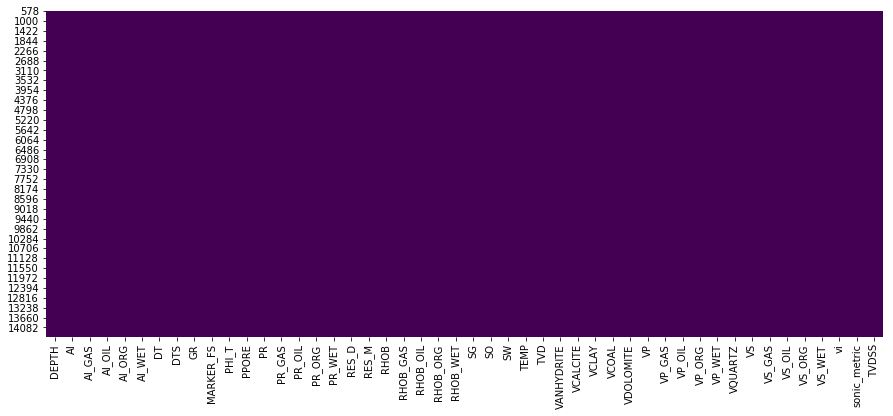

In [12]:
plt.figure(figsize=(15,6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)

## Replacement velocity input required

In [13]:
df['sonic_avg'] = (df.sonic_metric.shift(1) + df.sonic_metric) / 2000000
df.sonic_avg.iloc[0] = 1 / log_start_comb_vel # Replacement velocity

In [14]:
df.head()

,DEPTH,AI,AI_GAS,AI_OIL,AI_ORG,AI_WET,DT,DTS,GR,MARKER_FS,...,VQUARTZ,VS,VS_GAS,VS_OIL,VS_ORG,VS_WET,vi,sonic_metric,TVDSS,sonic_avg
578,388.2012,3386.8230,3386.8230,3386.8230,3477.8078,3386.8230,163.7600,479.5523,28.6094,0.0,...,0.9012,635.6006,635.6006,635.6006,635.6317,635.6006,1861.260381,537.263808,411.2012,0.000630
579,388.3536,3322.8153,3322.8153,3322.8153,3424.9941,3322.8153,165.7601,495.2100,30.2500,0.0,...,0.8616,615.5039,615.5039,615.5039,615.5339,615.5039,1838.801979,543.825736,411.3536,0.000541
580,388.5060,3276.2679,3276.2679,3276.2679,3340.8824,3276.2679,167.2602,507.4455,31.5469,0.0,...,0.8304,600.6629,600.6629,600.6629,600.6922,600.6629,1822.310388,548.747264,411.5060,0.000546
581,388.6584,3253.5708,3253.5708,3253.5708,3259.3385,3253.5708,167.7602,510.5992,31.0469,0.0,...,0.8428,596.9530,596.9530,596.9530,596.9821,596.9530,1816.879093,550.387664,411.6584,0.000550
582,388.8108,3238.6101,3238.6101,3238.6101,3224.5357,3238.6101,167.5102,505.2031,27.7344,0.0,...,0.9231,603.3291,603.3291,603.3291,603.3585,603.3291,1819.590688,549.567464,411.8108,0.000550


## One way time from checkshot to sonic value required

In [15]:
df['owt_int'] = (df.TVDSS - df.TVDSS.shift(1)) * df.sonic_avg
df.owt_int.iloc[0] = log_start_time # one way time to top of sonic log

In [16]:
df.head()

,DEPTH,AI,AI_GAS,AI_OIL,AI_ORG,AI_WET,DT,DTS,GR,MARKER_FS,...,VS,VS_GAS,VS_OIL,VS_ORG,VS_WET,vi,sonic_metric,TVDSS,sonic_avg,owt_int
578,388.2012,3386.8230,3386.8230,3386.8230,3477.8078,3386.8230,163.7600,479.5523,28.6094,0.0,...,635.6006,635.6006,635.6006,635.6317,635.6006,1861.260381,537.263808,411.2012,0.000630,0.188868
579,388.3536,3322.8153,3322.8153,3322.8153,3424.9941,3322.8153,165.7601,495.2100,30.2500,0.0,...,615.5039,615.5039,615.5039,615.5339,615.5039,1838.801979,543.825736,411.3536,0.000541,0.000082
580,388.5060,3276.2679,3276.2679,3276.2679,3340.8824,3276.2679,167.2602,507.4455,31.5469,0.0,...,600.6629,600.6629,600.6629,600.6922,600.6629,1822.310388,548.747264,411.5060,0.000546,0.000083
581,388.6584,3253.5708,3253.5708,3253.5708,3259.3385,3253.5708,167.7602,510.5992,31.0469,0.0,...,596.9530,596.9530,596.9530,596.9821,596.9530,1816.879093,550.387664,411.6584,0.000550,0.000084
582,388.8108,3238.6101,3238.6101,3238.6101,3224.5357,3238.6101,167.5102,505.2031,27.7344,0.0,...,603.3291,603.3291,603.3291,603.3585,603.3291,1819.590688,549.567464,411.8108,0.000550,0.000084


In [17]:
df['owt_cum'] = df.owt_int.cumsum()

In [18]:
df.head()

,DEPTH,AI,AI_GAS,AI_OIL,AI_ORG,AI_WET,DT,DTS,GR,MARKER_FS,...,VS_GAS,VS_OIL,VS_ORG,VS_WET,vi,sonic_metric,TVDSS,sonic_avg,owt_int,owt_cum
578,388.2012,3386.8230,3386.8230,3386.8230,3477.8078,3386.8230,163.7600,479.5523,28.6094,0.0,...,635.6006,635.6006,635.6317,635.6006,1861.260381,537.263808,411.2012,0.000630,0.188868,0.188868
579,388.3536,3322.8153,3322.8153,3322.8153,3424.9941,3322.8153,165.7601,495.2100,30.2500,0.0,...,615.5039,615.5039,615.5339,615.5039,1838.801979,543.825736,411.3536,0.000541,0.000082,0.188950
580,388.5060,3276.2679,3276.2679,3276.2679,3340.8824,3276.2679,167.2602,507.4455,31.5469,0.0,...,600.6629,600.6629,600.6922,600.6629,1822.310388,548.747264,411.5060,0.000546,0.000083,0.189033
581,388.6584,3253.5708,3253.5708,3253.5708,3259.3385,3253.5708,167.7602,510.5992,31.0469,0.0,...,596.9530,596.9530,596.9821,596.9530,1816.879093,550.387664,411.6584,0.000550,0.000084,0.189117
582,388.8108,3238.6101,3238.6101,3238.6101,3224.5357,3238.6101,167.5102,505.2031,27.7344,0.0,...,603.3291,603.3291,603.3585,603.3291,1819.590688,549.567464,411.8108,0.000550,0.000084,0.189201


## Plot owt_cum with checkshots

In [19]:
df['v_avg'] = df.TVDSS / df.owt_cum
#df.v_avg.iloc[0] = replacement_velocity

In [20]:
df.head()

,DEPTH,AI,AI_GAS,AI_OIL,AI_ORG,AI_WET,DT,DTS,GR,MARKER_FS,...,VS_OIL,VS_ORG,VS_WET,vi,sonic_metric,TVDSS,sonic_avg,owt_int,owt_cum,v_avg
578,388.2012,3386.8230,3386.8230,3386.8230,3477.8078,3386.8230,163.7600,479.5523,28.6094,0.0,...,635.6006,635.6317,635.6006,1861.260381,537.263808,411.2012,0.000630,0.188868,0.188868,2177.190863
579,388.3536,3322.8153,3322.8153,3322.8153,3424.9941,3322.8153,165.7601,495.2100,30.2500,0.0,...,615.5039,615.5339,615.5039,1838.801979,543.825736,411.3536,0.000541,0.000082,0.188950,2177.048207
580,388.5060,3276.2679,3276.2679,3276.2679,3340.8824,3276.2679,167.2602,507.4455,31.5469,0.0,...,600.6629,600.6922,600.6629,1822.310388,548.747264,411.5060,0.000546,0.000083,0.189033,2176.895598
581,388.6584,3253.5708,3253.5708,3253.5708,3259.3385,3253.5708,167.7602,510.5992,31.0469,0.0,...,596.9530,596.9821,596.9530,1816.879093,550.387664,411.6584,0.000550,0.000084,0.189117,2176.737369
582,388.8108,3238.6101,3238.6101,3238.6101,3224.5357,3238.6101,167.5102,505.2031,27.7344,0.0,...,603.3291,603.3585,603.3291,1819.590688,549.567464,411.8108,0.000550,0.000084,0.189201,2176.578560


In [21]:
df['vi_med21'] = df.vi.rolling(21).median()

Text(0.5,0,'Depth (tvdss)')

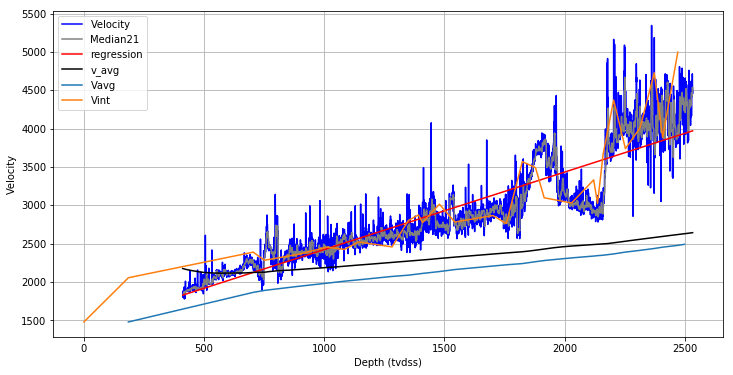

In [68]:
reg = np.polyfit(df.TVDSS, df.vi, deg=1)
ry = np.polyval(reg, df.TVDSS)

plt.figure(figsize=(12,6))
plt.plot(df.TVDSS, df.vi,  'b', label='Velocity')
plt.plot(df.TVDSS, df.vi_med21,  'gray', label='Median21')
plt.plot(df.TVDSS, ry, 'r', label='regression')
plt.plot(df.TVDSS, df.v_avg, 'black')
plt.plot(cshots[ cshots['Well']=='7120/12-03']['TVDSS'], cshots[ cshots['Well']=='7120/12-03']['Vavg'] )
plt.plot(cshots[ cshots['Well']=='7120/12-03']['TVDSS'], cshots[ cshots['Well']=='7120/12-03']['Vint'] )
#plt.plot(df.md, df.v_rms, 'green')
plt.legend(loc=0)
plt.grid(True)
plt.ylabel('Velocity')
plt.xlabel('Depth (tvdss)')
#plt.invert_yaxis()